In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [2]:
# scouter MSE (not normalized)
subgroup_df = pd.read_csv('../../results/Scouter/Scouter_norman_result.csv', index_col=0)
mse_ls = []
pert_ls = []
split_ls = []
subgroup_ls = []
for split in range(1, 6):
    path = f'../../results/Scouter/Scouter_norman_{split}.pkl'
    subgroup_split = subgroup_df[subgroup_df.split == split]
    subgroup_dict = dict(zip(subgroup_split.index, subgroup_split.subgroup))
    with open(path, 'rb') as f:
        scouter_split = pickle.load(f)
        for pert, res in scouter_split.items():
            pred = res['Pred'].mean(axis=0)
            true = res['Truth'].mean(axis=0)
            mse_pert = mse(pred, true)
            mse_ls.append(mse_pert)
            pert_ls.append(pert)
            split_ls.append(split)
            subgroup_ls.append(subgroup_dict[pert])

df = pd.DataFrame({'MSE': mse_ls, 'split': split_ls, 'subgroup': subgroup_ls}, index=pert_ls)
scouter_mean = df.groupby('subgroup').MSE.mean()

# GEARS MSE (not normalized)
degs_all = pickle.load(open('../../results/degs_all.pkl', 'rb'))
exclude_genes = ['GARS', 'WDR61', 'C12orf45', 'INTS2', 'POLR2B', 'ZNF720', 'PRELID3B', 'C5orf30', 'SPATA5L1']
def read_metric(path, dataset, method):
    with open(path, 'rb') as f:
        dict_split = pickle.load(f)
        split = {}
        for k, v in dict_split.items():
            # get perturbation condition key
            if any(gene in k for gene in exclude_genes):
                continue
            true, pred, ctrl, _ = v.values()
            if method == 'biolord':
                pert_key = k.split('_')[1]
            elif method == 'gears':
                if dataset == 'adamson':
                    pert_key = f'{k}+ctrl'
                else:
                    pert_key = k
            if dataset == 'norman':
                pert_key = '+'.join(sorted(pert_key.split('+')))
            de_idx = degs_all[dataset][pert_key]
            mse_k = mse(true[de_idx], pred[de_idx])
            split[k] = {'MSE':mse_k}
        split = pd.DataFrame.from_dict(split, orient='index')
    return split


gears_norman = []
for i in range(1,6):    
    gears_single = read_metric(f'../../results/GEARS/GEARS_norman_unseen_single_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='single')
    gears_seen0 = read_metric(f'../../results/GEARS/GEARS_norman_combo_seen0_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='seen0')
    gears_seen1 = read_metric(f'../../results/GEARS/GEARS_norman_combo_seen1_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='seen1')
    gears_seen2 = read_metric(f'../../results/GEARS/GEARS_norman_combo_seen2_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='seen2')
    gears_norman.append(pd.concat([gears_single, gears_seen0, gears_seen1, gears_seen2]))
gears_norman = pd.concat(gears_norman).assign(Method='GEARS')
gears_mean = gears_norman.groupby('subgroup').MSE.mean()


# scFoundation MSE (read from paper)
scf_mean = pd.Series({"single": 0.188, "seen2": 0.11, "seen1": 0.184, "seen0": 0.23})

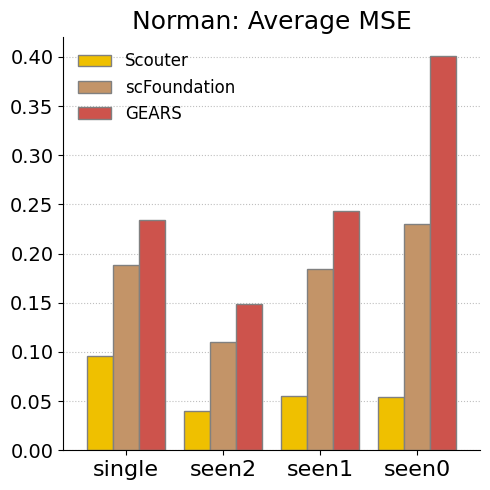

In [3]:
########################### Plot ###########################
order = ["single", "seen2", "seen1", "seen0"]
combined_df = pd.DataFrame({
    'Scouter': scouter_mean[order],
    'scFoundation': scf_mean[order],
    'GEARS': gears_mean[order]
})

custom_colors = {
    'Scouter': '#efc000',
    'scFoundation': '#c39468',
    'GEARS': '#cd534c'
}

ax = combined_df.plot(figsize=(5,5),
                      kind='bar',
                      color=[custom_colors[col] for col in combined_df.columns],
                      edgecolor='gray',
                      width=0.8,
                      legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle=':', color='gray', alpha=0.5, zorder=0)
ax.set_axisbelow(True)
plt.ylabel("")
plt.title('Norman: Average MSE', fontsize=18)
plt.ylim(0, 0.42)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, frameon=False, ncol=1)
plt.tight_layout()
plt.show()